In [ ]:
import os
import re
import time
import datetime
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
%matplotlib inline

import jieba
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models





c:\Users\rolya\anaconda3\envs\Syllabus\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


# 主題 : 核電議題的民意與政見分析
# 動機
從不同角度 (民眾、政黨) 觀察台灣對於核電廠的態度，分析層面大概會分成兩種 : 
+ ### 民眾層面
    + 利用 PTT（八卦板、政黑板）文章進行情緒分析，探討討論核電議題時的正負向情緒變化與趨勢
    + 分析不同時間點上民眾情緒的高低與波動，並嘗試關聯特定社會事件或政治背景
+ ### 政黨層面
  + 透過主題模型分析政黨與核電議題的關聯主題

# 資料介紹 - 核電
+ 資料來源 : PTT
+ 看板 : 政黑 (HatePlitics)、八卦 (Gossiping)
+ 時間 : 2021/7 ~ 2025/6

# 影片連結 : https://youtu.be/FIakCeG6M5k


# 資料前處理

## 匯入資料

In [347]:
df1 = pd.read_csv("HatePolitics.csv")
df2 = pd.read_csv("Gossiping.csv")

df = pd.concat([df1, df2], ignore_index=True)
df.to_csv("PTT_Nuclear.csv", index=False, encoding="utf-8-sig")

df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,chihchingho,HatePolitics,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Tattoo"", ""cm...",223.140.25.201,2021-06-01 03:10:22,ptt
1,2,https://www.ptt.cc/bbs/HatePolitics/M.16225748...,Re:[黑特]民進黨20222024怎麼選,2021-06-02,larrytang,HatePolitics,現任馬里蘭州州長Larry Hogan因為太太是韓國第一代移民，對移民非常友好，也因此對中國...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""taipoo"", ""cm...",174.244.210.225,2021-06-03 03:02:08,ptt
2,3,https://www.ptt.cc/bbs/HatePolitics/M.16226249...,[討論]民進黨比較適合當在野黨,2021-06-02,stevencool,HatePolitics,2008年那次立委剩27席\n\n黨團總召柯建銘 幹事長賴清德\n\n監督起馬政府是虎虎生風...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""icolee"", ""cm...",1.174.11.170,2021-06-03 03:04:06,ptt
3,4,https://www.ptt.cc/bbs/HatePolitics/M.16226918...,[新聞]韓環團出動100多艘漁船反對日本排核廢水,2021-06-03,CRESTY,HatePolitics,1.新聞網址︰\nhttps://news.ltn.com.tw/news/world/br...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""dakkk"", ""cmt...",27.242.3.80,2021-06-04 01:43:23,ptt
4,5,https://www.ptt.cc/bbs/HatePolitics/M.16231218...,Re:[新聞]5月底請辭陳培哲:最大困難就是來自蔡英文,2021-06-08,areses,HatePolitics,雖然我們一直說政治不能凌駕於科學，但那是正常情況下，政治本來就是一切社會關係的總\n和，也是...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""JamesSoong"",...",223.104.20.205,2021-06-09 01:53:43,ptt


## 資料清理

In [348]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,大家安安。老實說民進黨政府不知道為何常常堅持一堆奇怪的點。20幾年歷史的核電就算了。蔡政府第...
1,https://www.ptt.cc/bbs/HatePolitics/M.16225748...,Re:[黑特]民進黨20222024怎麼選,2021-06-02,現任馬里蘭州州長Larry Hogan因為太太是韓國第一代移民，對移民非常友好，也因此對中國...,現任馬里蘭州州長Larry Hogan因為太太是韓國第一代移民，對移民非常友好，也因此對中國...
2,https://www.ptt.cc/bbs/HatePolitics/M.16226249...,[討論]民進黨比較適合當在野黨,2021-06-02,2008年那次立委剩27席\n\n黨團總召柯建銘 幹事長賴清德\n\n監督起馬政府是虎虎生風...,2008年那次立委剩27席。黨團總召柯建銘 幹事長賴清德。監督起馬政府是虎虎生風。蔡英文的第...
3,https://www.ptt.cc/bbs/HatePolitics/M.16226918...,[新聞]韓環團出動100多艘漁船反對日本排核廢水,2021-06-03,1.新聞網址︰\nhttps://news.ltn.com.tw/news/world/br...,1.新聞網址︰ 反對日本排核廢水入海4.完整新聞內容︰2021/06/02 20:57〔即時...
4,https://www.ptt.cc/bbs/HatePolitics/M.16231218...,Re:[新聞]5月底請辭陳培哲:最大困難就是來自蔡英文,2021-06-08,雖然我們一直說政治不能凌駕於科學，但那是正常情況下，政治本來就是一切社會關係的總\n和，也是...,雖然我們一直說政治不能凌駕於科學，但那是正常情況下，政治本來就是一切社會關係的總和，也是控制...


## 斷句

In [349]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,大家安安
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,老實說民進黨政府不知道為何常常堅持一堆奇怪的點
2,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,20幾年歷史的核電就算了
3,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,蔡政府第一任抓著小辮子卡管中閔當校長
4,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,結果還是要給他聘書


In [350]:
jieba.set_dictionary('dict.txt')

In [351]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,大家安安
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,老實說民進黨政府不知道為何常常堅持一堆奇怪的點
2,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,20幾年歷史的核電就算了
3,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,蔡政府第一任抓著小辮子卡管中閔當校長
4,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,結果還是要給他聘書


## 文章斷詞

In [352]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head()

Building prefix dict from c:\Users\rolya\Downloads\社群期末\dict.txt ...
Loading model from cache C:\Users\rolya\AppData\Local\Temp\jieba.u79b1ff2e48bc0a968a496524a112d88f.cache
Loading model cost 0.647 seconds.
Prefix dict has been built successfully.


,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,大家
0,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,安安
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,老實說
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,民進黨
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,政府


## 移除停用字

In [353]:
stopwords = [line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8').readlines()] 
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head()

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,安安
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,老實說
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,民進黨
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,政府
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,[討論]政府直接跟上海復星買就沒這麼多問題吧？,2021-06-01,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,知道


# Lexicon-based 情緒分析

## 情緒字典與斷詞結果進行合併

In [354]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,安安,NaN
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,老實說,NaN
2,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,民進黨,NaN
3,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,政府,NaN
4,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,知道,NaN


## 正負向情緒詞彙頻率折線圖

In [355]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count.head(10)

,artDate,sentiments,size
2,2021-06-01,negative,11
6,2021-06-02,negative,18
7,2021-06-02,positive,14
12,2021-06-03,negative,11
13,2021-06-03,positive,17
17,2021-06-04,negative,7
18,2021-06-04,positive,6
24,2021-06-06,positive,15
23,2021-06-06,negative,17
28,2021-06-07,negative,22


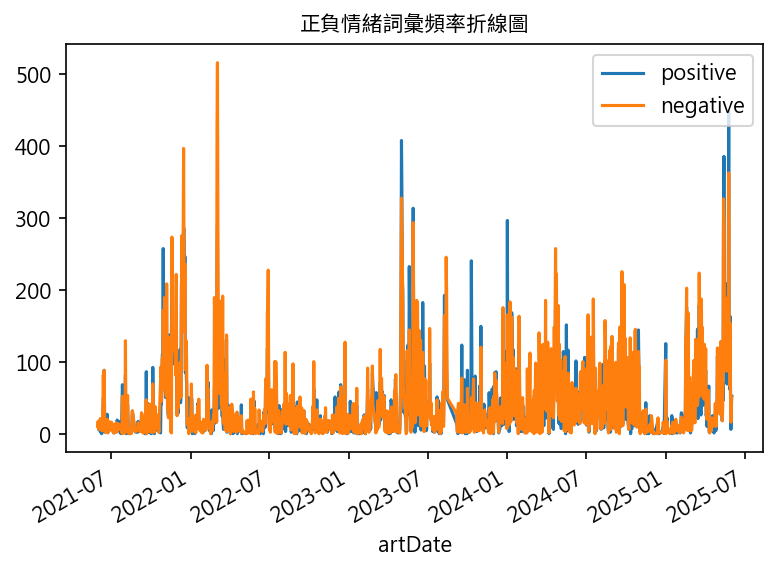

In [356]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="SourceHanSansTW-Regular.otf")

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()


negative波動較大，常出現高峰：代表整體而言，負面情緒在討論核電時佔比較高，尤其在某些事件爆發時會有極大波動（例如破 400～500 的高峰）。<br>
positive相對平穩但較弱勢：正向詞彙的使用頻率明顯低於負面詞彙，幾乎沒有主導過情緒討論。<br>

時間上看，負面高峰多出現在：<br>
2022年初：可能與能源政策、電價、核四爭議相關。<br>
2024年與2025年初也有多次小波動，可能與選舉、事故或能源短缺討論有關。<br>

初步推論：民眾對核電議題的情緒偏向負面，正面聲音較少而分散，高峰常與政治或事件驅動有關。

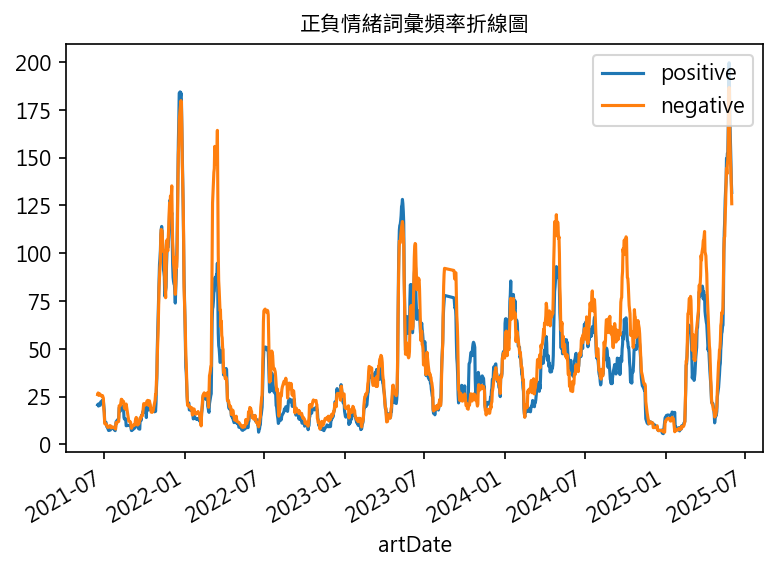

In [357]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

正負情緒差距縮小：顯示討論逐漸多元，可能出現了更多立場交鋒或理性討論，而不再是單向的負面主導。<br>

幾次明顯的同步波動點：<br>
2022年初：明顯高峰。<br>
2023年中與2025年初：也有明顯波動，可能對應特定重大新聞或社會事件。<br>

推論補充：<br>
平滑圖反映出整體討論氛圍的趨勢，有逐步朝「情緒對立但均衡」的方向走。<br>
從2023年以後，正面情緒雖仍較弱，但已不再完全邊緣化，反映某些言論空間擴大或支持核能的聲音逐步浮現。

## 正負向情緒詞彙比例折線圖

Text(0.5, 1.0, '正負情緒比例折線圖')

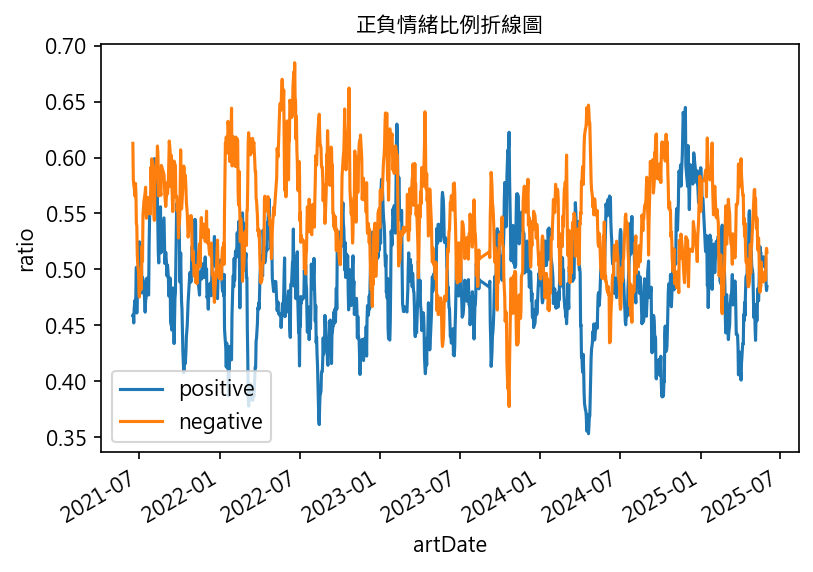

In [358]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)

pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

negative大多數時間比positive高，代表在多數時期負面詞的佔比高於正面詞。<br>

雖然兩者皆在 0.4～0.65 間波動，但整體觀察下來：<br>
2022 年初～中：負面比例顯著高（達到 0.65），應為事件高峰期。<br>
2024 年中以後：正負比例開始出現多次交叉，代表意見趨於平衡或爭論升溫。<br>

出現「正面比例明顯上升」的時間：<br>
2023 年中與 2025 年中後，顯示討論中有越來越多支持核電、或理性看待核能的聲音。<br>

小結：這張圖呈現出情緒結構上的變化趨勢，從單一負面主導 → 朝正負共存發展。

## 正負向情緒分數折線圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

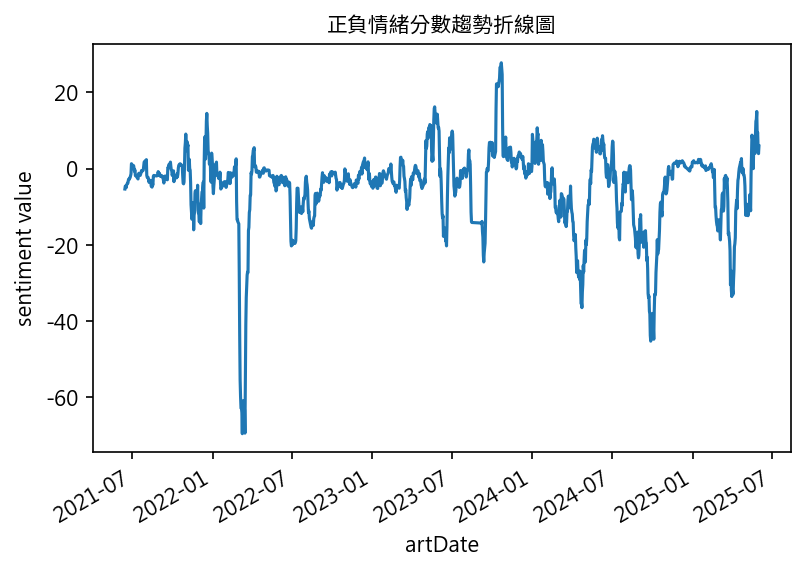

In [359]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)

plt.rcParams["axes.unicode_minus"] = False
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

可以明顯看到：<br>
2022 年中出現深度低谷（-60 左右），可能為核災、缺電、核四爭議等事件爆發。<br>
其他幾個負面谷底分別在 2023-06、2024-07、2025-01。<br>
2025 年中後快速拉升至正值區間，顯示近期整體情緒出現翻轉或大量正面文章湧入。


## 文章為單位的情緒分析

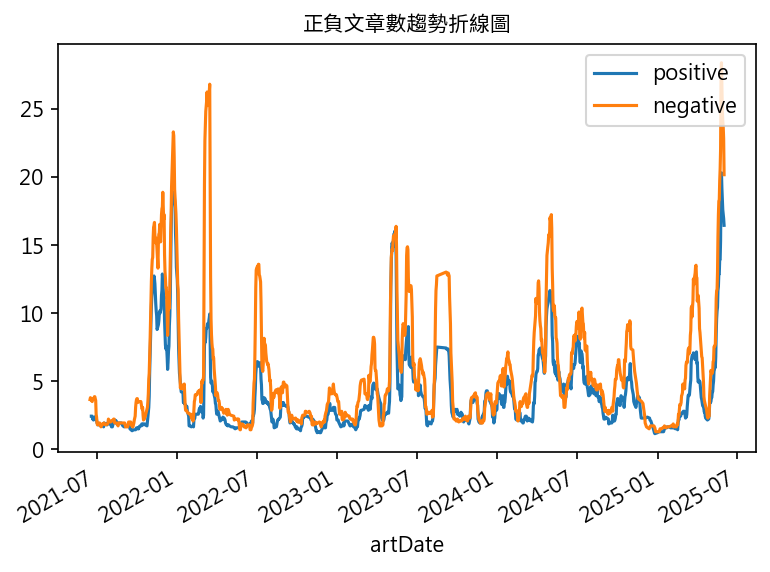

In [360]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})

ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)

ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )

clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])

colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

可以觀察到：<br>
2022年初～中：負面文章數顯著高，正面文章也有小波動，但較少。<br>
2023 年後：正負數量趨於接近，尤其在某些高峰期（如2024-01、2025-06）幾乎重疊。<br>
2025年中：正面文章突然大量增加，與前張圖趨勢一致，顯示近期明顯轉向正向情緒。

## 情緒代表字

C:\Users\rolya\AppData\Local\Temp\ipykernel_10104\2728981295.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\rolya\AppData\Local\Temp\ipykernel_10104\2728981295.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

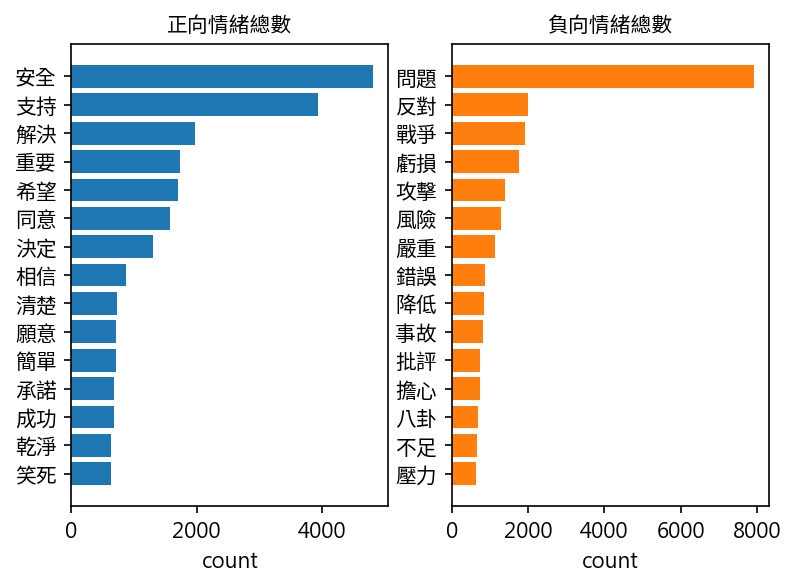

In [361]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 檢查情緒詞是否符合本文本

In [371]:
filtered_df = sent_df[sent_df['sentence'].str.contains('摧毀', na=False)]

for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

石化燃料正在摧毀地球
接著摧毀所有海上風力發電設施的時候怎麼辦
今天是摧毀藻礁
被摧毀的城市是面的災害
車諾比核電廠旁開火　核廢料設施遭摧毀
一核廢料儲存設施遭到摧毀
如果核廢料儲存設施因砲擊被摧毀
目前尚無法得知核廢料設施被摧毀是否有造成輻射污染的狀況
更直言莫斯科想藉由摧毀國家元首來從政治上擊敗烏克蘭
他們想透過摧毀國家元首
烏克蘭軍方稱有40輛俄軍裝甲車在科諾托普 Konotop 地區被摧毀
無論白天夜晚都會很危險破壞組織正在摧毀基輔的軍事和執法機構
摧毀烏軍67輛坦克和其他裝甲戰車16組多管火箭砲87輛特種軍用車
摧毀了俄軍80輛坦克500多輛軍用車10架戰機和7架直升機
台電一再發生一人摧毀全台電力事件
一再發生一人摧毀全台電力事件
已摧毀251輛俄羅斯戰車939輛裝甲運兵車
俄羅斯軍隊在烏克蘭第二大城市摧毀了一個受到國際安全保護的原子物理實驗室
這已經是本市被砲火摧毀的第三家醫院了
摧毀大量國際軍援
十天前俄軍以飛彈摧毀當地的機場
摧毀烏克蘭位於黑海的重鎮奧德薩Odessa附近的無線電與電子偵防據點
俄軍已摧毀烏軍196架無人機1438輛坦克與其他戰車145組多重火箭發射器556件野戰砲與迫擊砲1237輛裝甲車
俄軍使用匕首飛彈摧毀烏克蘭西南部伊凡法蘭科夫州IvanoFrankivsk的村落傑利亞京Deliatyn一處地下軍火庫法新社向俄國國防部求證
俄國國防部宣稱俄軍昨318以米格31戰機發射匕首飛彈摧毀這處軍火庫
摧毀這道牆
這就是我要對你親愛的蕭茲總理說的話摧毀這道牆
台灣的飛彈有能力摧毀三峽大壩
戰爭就是無差別亂摧毀設施 人命 經濟
與中國發生衝突的恐懼正在摧毀我們的寬容和文明
以摧毀我們最大的經濟資產之一
要吃要拿還要摧毀台灣沒核電做基載光靠天然氣合理嗎
已經被摧毀
怎麽摧毀歐洲工業
已經被中國摧毀的是歐豬
結果罵光電說摧毀良田 罵風電說貴傷害白海豚
變成要摧毀全部分散的光電板才會一片漆黑
絕不容許台獨勢力傷害摧毀中華民國
同文這段話很有趣如果甘迺迪成功在八月的全國民主黨大會中摧毀總統
試圖摧毀其電網
買一堆天然氣反而會摧毀台灣國防
這樣的核武將足以摧毀一整個俄羅斯空軍基地
文革的重點就是要把既有價值觀都摧毀才能把共產黨那些歪理洗腦給韭菜
等待死亡的那刻 是漫長的時間 核輻射過量摧毀了全身的DNA 細胞沒了藍圖 被代謝的細胞
岸邊的天然氣接收站

### 重新計算情緒<br>
拿掉不符合文本之："戰爭", "攻擊", "笑死", "八卦", "和平","自由", "入侵"

In [460]:
# 設定要移除的字詞列表
words_to_remove = ["戰爭", "攻擊", "笑死", "八卦", "和平","自由", "入侵"]
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,安安,NaN
1,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,老實說,NaN
2,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,民進黨,NaN
3,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,政府,NaN
4,https://www.ptt.cc/bbs/HatePolitics/M.16224802...,2021-06-01,[討論]政府直接跟上海復星買就沒這麼多問題吧？,大家安安\n\n老實說民進黨政府不知道為何常常堅持一堆奇怪的點\n\n20幾年歷史的核電就算...,知道,NaN


C:\Users\rolya\AppData\Local\Temp\ipykernel_10104\2708770589.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\rolya\AppData\Local\Temp\ipykernel_10104\2708770589.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

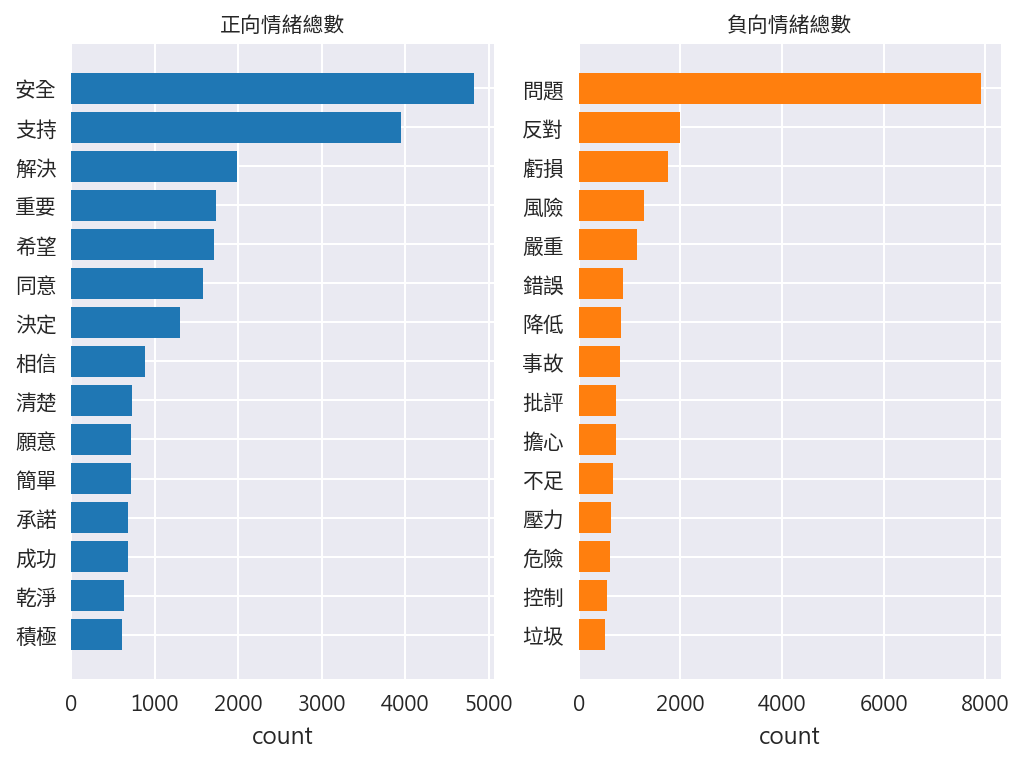

In [462]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()

word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

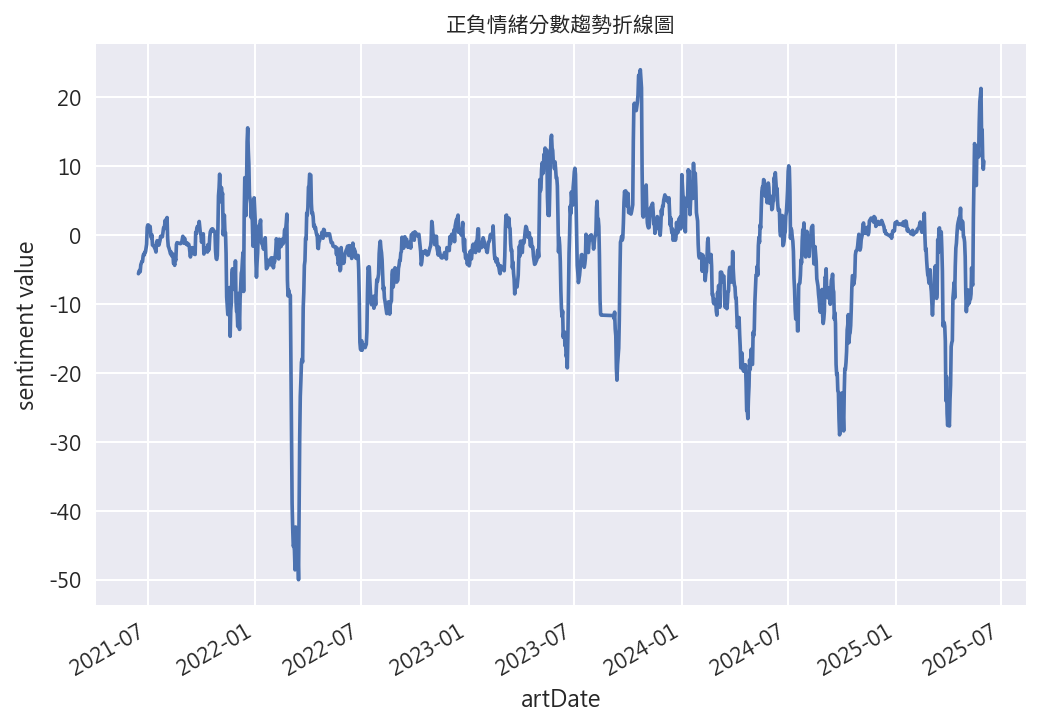

In [463]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

重新觀察：<br>
數值落點比上一張更偏中間區間（-50 ～ +20）。<br>
多數時間情緒值在 -10～+10 間波動，呈現 反覆拉鋸。<br>
最低谷仍然出現在 2022 年中，與核安爭議高度相關。<br>
2025 年中情緒回升，正面評價佔優勢，與文章數趨勢圖一致。

## 文字雲

In [383]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")

sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")

date = "2022-01-15"
end_date = "2022-04-15"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc.head(10)

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
91095,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,全世界,NaN,負向
91096,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,剩下,NaN,負向
91097,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,台灣,NaN,負向
91098,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,中國,NaN,負向
91099,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,不許,NaN,負向
91100,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,進口,NaN,負向
91101,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,福島,NaN,負向
91102,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,食物,NaN,負向
91103,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,核電廠,NaN,負向
91104,https://www.ptt.cc/bbs/HatePolitics/M.16423935...,2022-01-17,[討論]福食VS核廢料藍青年領袖巧芯覺得哪危險?,全世界只剩下台灣跟中國不許進口的福島食物\n跟只要有核電廠就會有的核廢料 但是可以接受放家...,廢料,NaN,負向


In [384]:
date = "2022-01-15"
end_date = "2022-04-15"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})

word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count.head(10)

,word,size
10719,烏克蘭,1000
5309,問題,756
9588,核電廠,749
4999,台灣,650
3447,俄羅斯,592
9586,核電,466
8851,新聞,404
12744,能源,377
3451,俄軍,364
3589,停電,341


(-0.5, 1599.5, 799.5, -0.5)

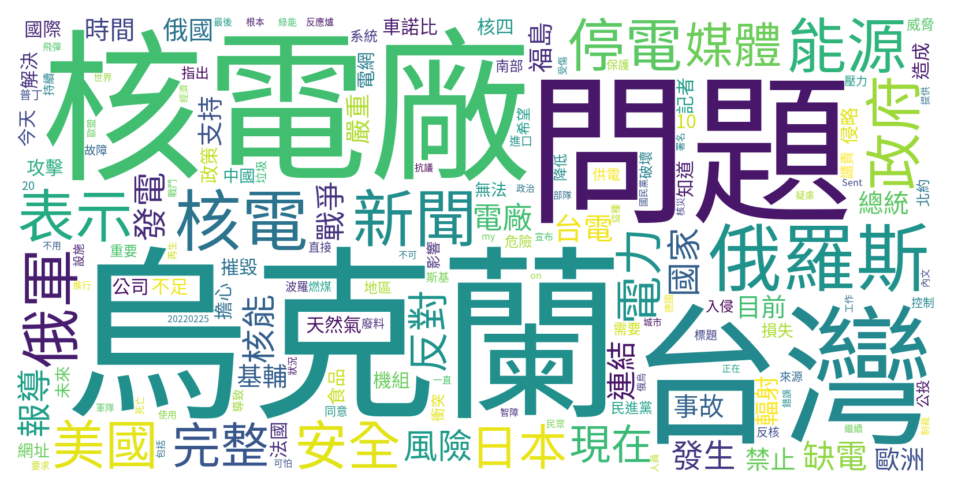

In [386]:
# wordcloud 的 input 是 dictionary
font_path = "SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

觀察重點：<br>
「核電廠」「核電」「烏克蘭」「台灣」「問題」為最核心字詞，顯示這些是討論主體。<br>
出現「俄羅斯」「美國」「天然氣」「媒體」「停電」等字詞，顯示與國際能源地緣政治議題相關。<br>
關鍵動詞與情緒類詞：如「表示」「安全」「風險」「發生」「禁止」「支持」「危險」呈現對立語境。<br>

推論：<br>
這張圖顯示核電議題與國際情勢高度連結（如俄烏戰爭、能源危機），國內外媒體報導與政策討論是討論主要來源。負面關鍵詞如「問題」「風險」與正面如「安全」「支持」並存，吻合先前圖表中「情緒逐漸多元」的觀察。

(-0.5, 1599.5, 799.5, -0.5)

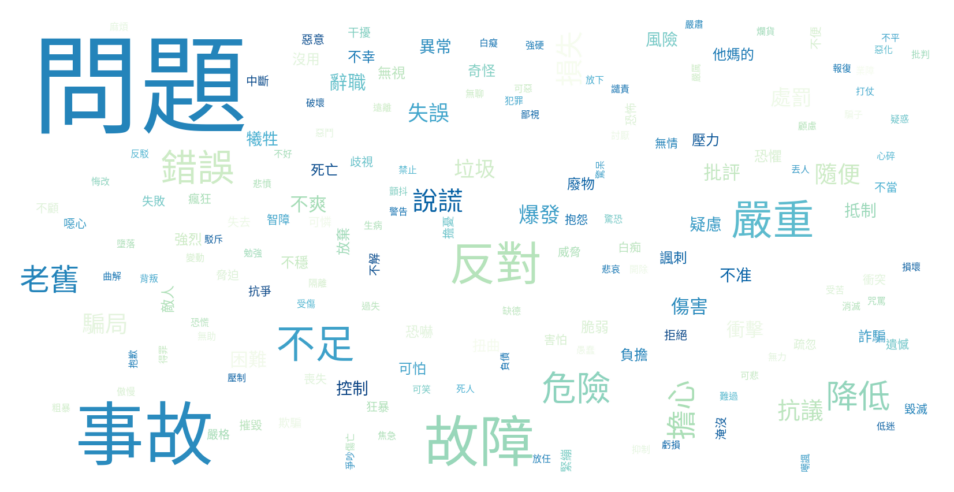

In [388]:
date = "2022-01-15"
end_date = "2022-04-15"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('停電')) & ( # 內文包含停電
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

推論：<br>
這張圖反映出 PTT 貼文的負面語言具有多層次——從理性批評（如風險、故障）到高度主觀或情緒化（如垃圾、不爽、說謊、爆發），顯示核電議題在社群平台引發情緒化討論與「非理性恐懼」的可能性。

In [395]:
date = "2022-01-15"
end_date = "2022-04-15"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('停電')) & (
    sent_df['sentence'].str.contains('問題')) # 包含「問題」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df[['artTitle', 'sentence', 'sentiment_class']]

,artTitle,sentence,sentiment_class
21061,[黑特]斷電跟重啟核四有關係嗎？,大家都知道,正向
21062,[黑特]斷電跟重啟核四有關係嗎？,要是很安全可靠解開這個困境,正向
21063,[黑特]斷電跟重啟核四有關係嗎？,我的意見是,正向
21064,[黑特]斷電跟重啟核四有關係嗎？,不如蓋核五,正向
21065,[討論]停電就扯公投才是輸不起吧？,公投是反核電,負向
...,...,...,...
163591,[問卦]死忠的其實才是優質選民吧?,就揶揄了他南部畢竟是死忠的才會這樣停水停電,負向
163592,[問卦]死忠的其實才是優質選民吧?,這時肥肥同學態度突然變得很嚴肅,負向
163593,[問卦]死忠的其實才是優質選民吧?,語重心長的對我說,負向
163594,[問卦]死忠的其實才是優質選民吧?,其實我們南部死忠的,負向


評估：<br>
整體分類邏輯尚可接受，句子中若出現如「安全、解決、支持」傾向被歸類為正向；<br>
而「反核、公投反對、死忠、停電、廢物」等語詞語境偏批判性，會被歸為負向。

# 使用CKIP進行情緒分析

In [396]:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\rolya\anaconda3\envs\Syllabus\Lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\rolya\anaconda3\envs\Syllabus\Lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\rolya\anaconda3\envs\Syllabus\Lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.n

## CKIP 標註
### 用CKIP進行處理

In [401]:
def Segmentation_Core(data, tokenizer):
    regexPattern = '|'.join(map(re.escape, tokenizer))
    out = re.split(regexPattern, data)
    return list(filter(None, out))          # 去掉空白行


def Sentence_Segmentation(article,
                          keep_digits=False,
                          keep_alphabets=False):
    """
    將文章依分號、句號、驚嘆號、問號…等斷句，並清掉特殊符號。
    * 已加入防呆：若 article 不是字串或為 NaN，直接視為空字串。
    """
    # ----------- ① 防呆處理 -----------
    if not isinstance(article, str):
        article = ""                         # 將 NaN / float 轉空字串

    # ----------- ② 正則參數 -----------
    sepical_symbols = r"""[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+"""
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")

    # ----------- ③ 文章先按換行符切段 -----------
    paragraphs = [p for p in article.split("\n")
                  if re.sub(r"\s+", "", p)]      # 去掉純空白行

    result = []
    for paragraph in paragraphs:
        clean = paragraph

        # 移除數字 / 英文
        if not keep_digits:
            clean = re.sub(r"\d*\.?\d+", "", clean)
        if not keep_alphabets:
            clean = re.sub(r"[a-zA-Z]+", "", clean)

        # 移除多空白與特殊符號
        clean = re.sub(r"\s+", "", clean)
        clean = re.sub(sepical_symbols, "", clean)

        # 斷句
        sent_list = Segmentation_Core(clean, segmentation_used_note)
        result.append(sent_list)

    return result

In [402]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [403]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 7990.67490029335


In [406]:
# 將文章存成csv
pos_table.to_csv('pos_table_Nu.csv', index = False)
entity_table.to_csv('entity_table_Nu.csv', index = False)
sentence_table.to_csv('sentence_table_Nu.csv', index = False)

## 探索分析 - NER

Text(0.5, 0, 'Frequency')

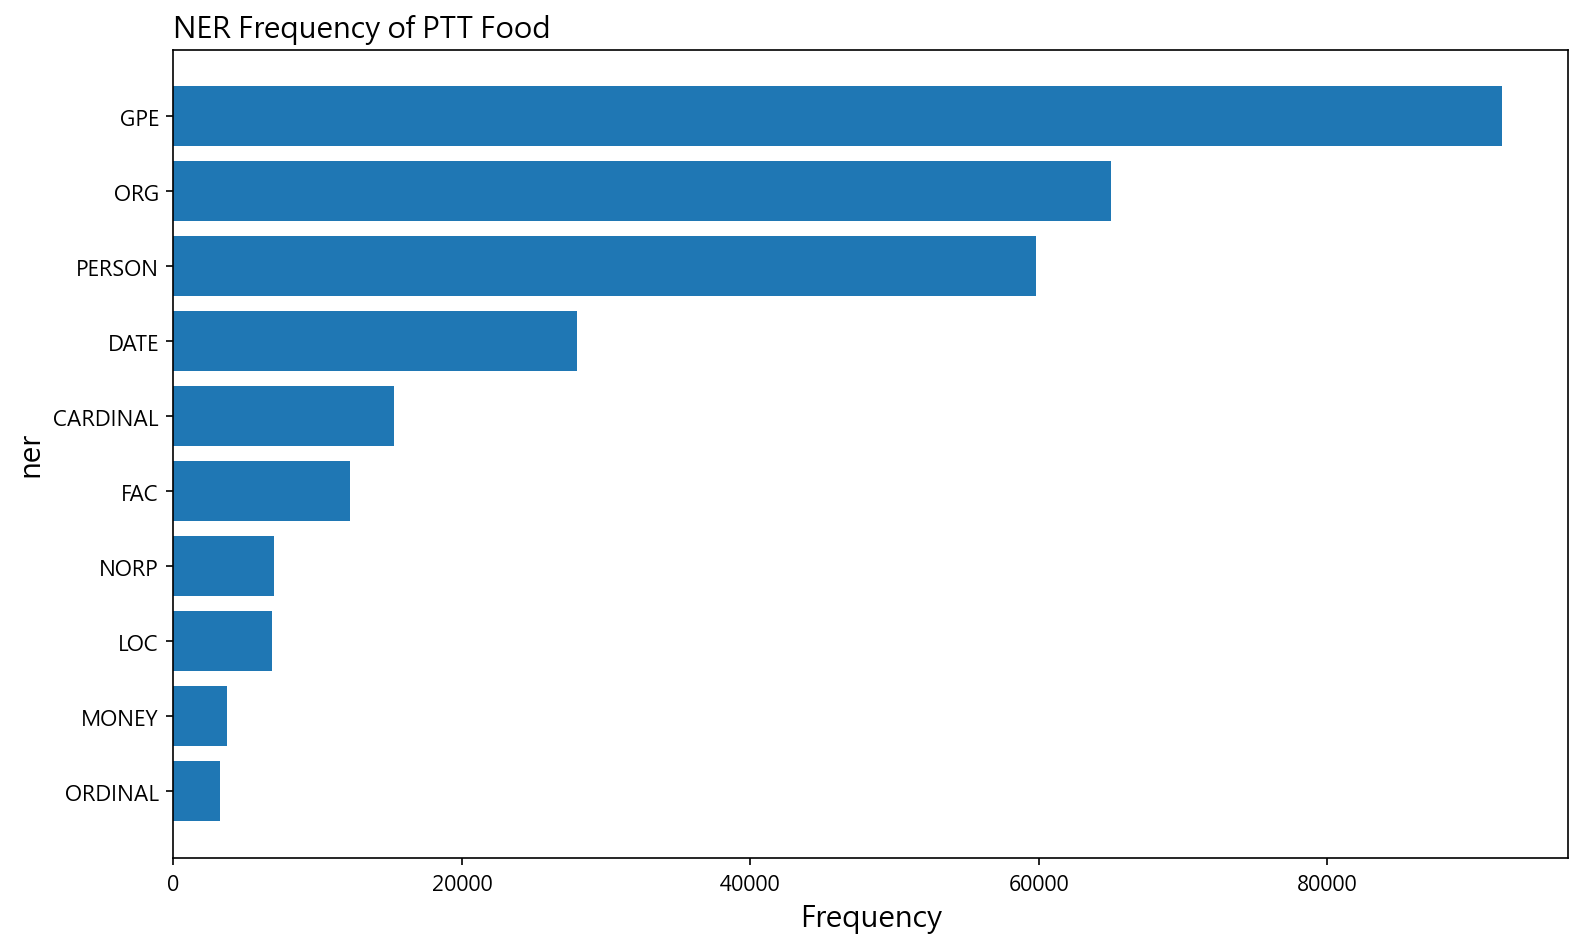

In [408]:
pos_table = pd.read_csv("pos_table_Nu.csv") 
entity_table = pd.read_csv("entity_table_Nu.csv") 
sentence_table = pd.read_csv("sentence_table_Nu.csv") 

ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)

ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
# fig.show()

Text(0.5, 0, 'Word Frequency')

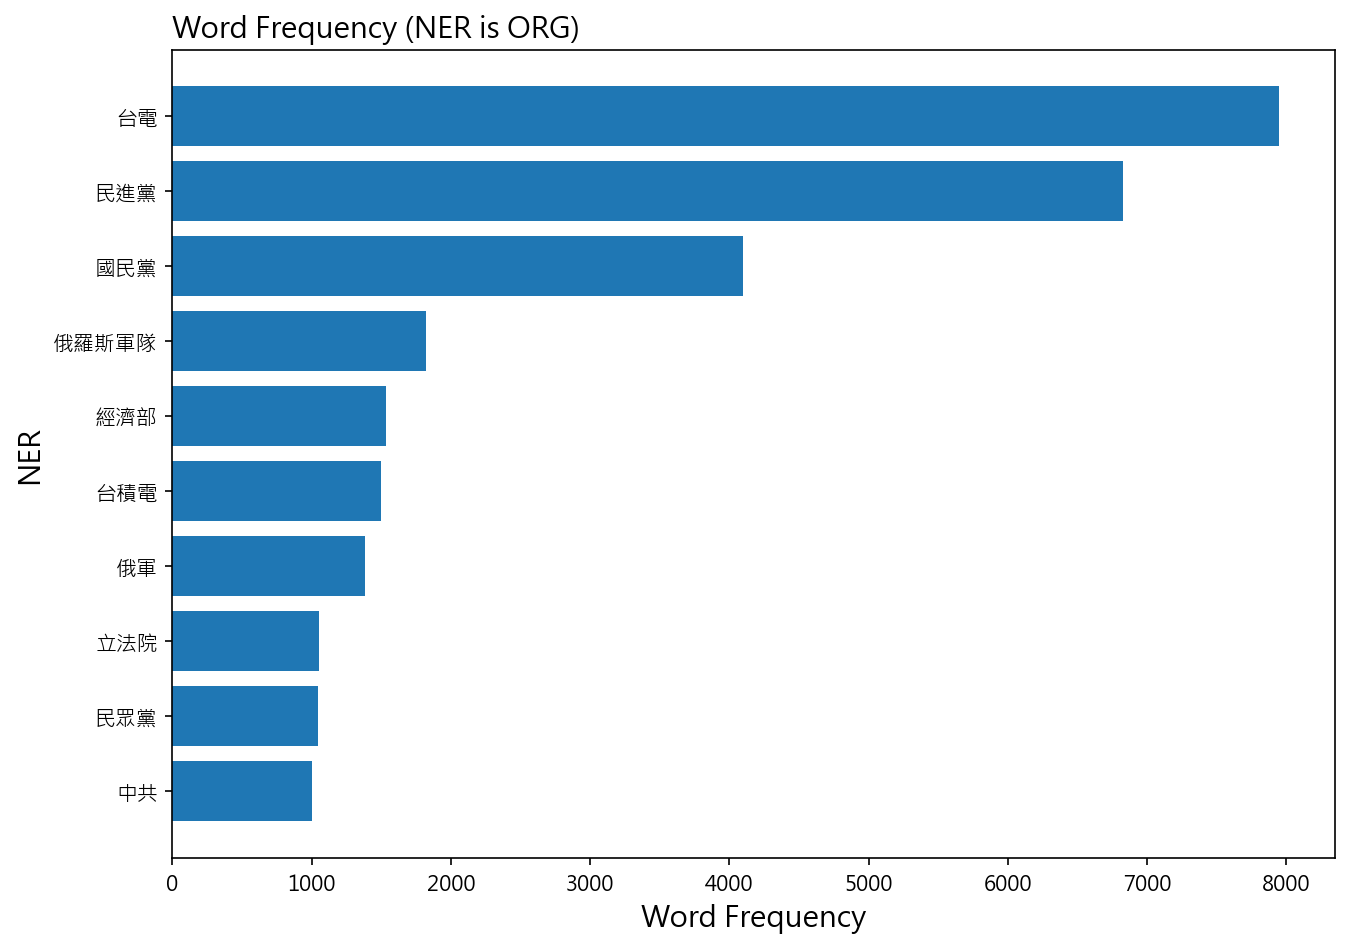

In [414]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

Text(0.5, 0, 'Word Frequency')

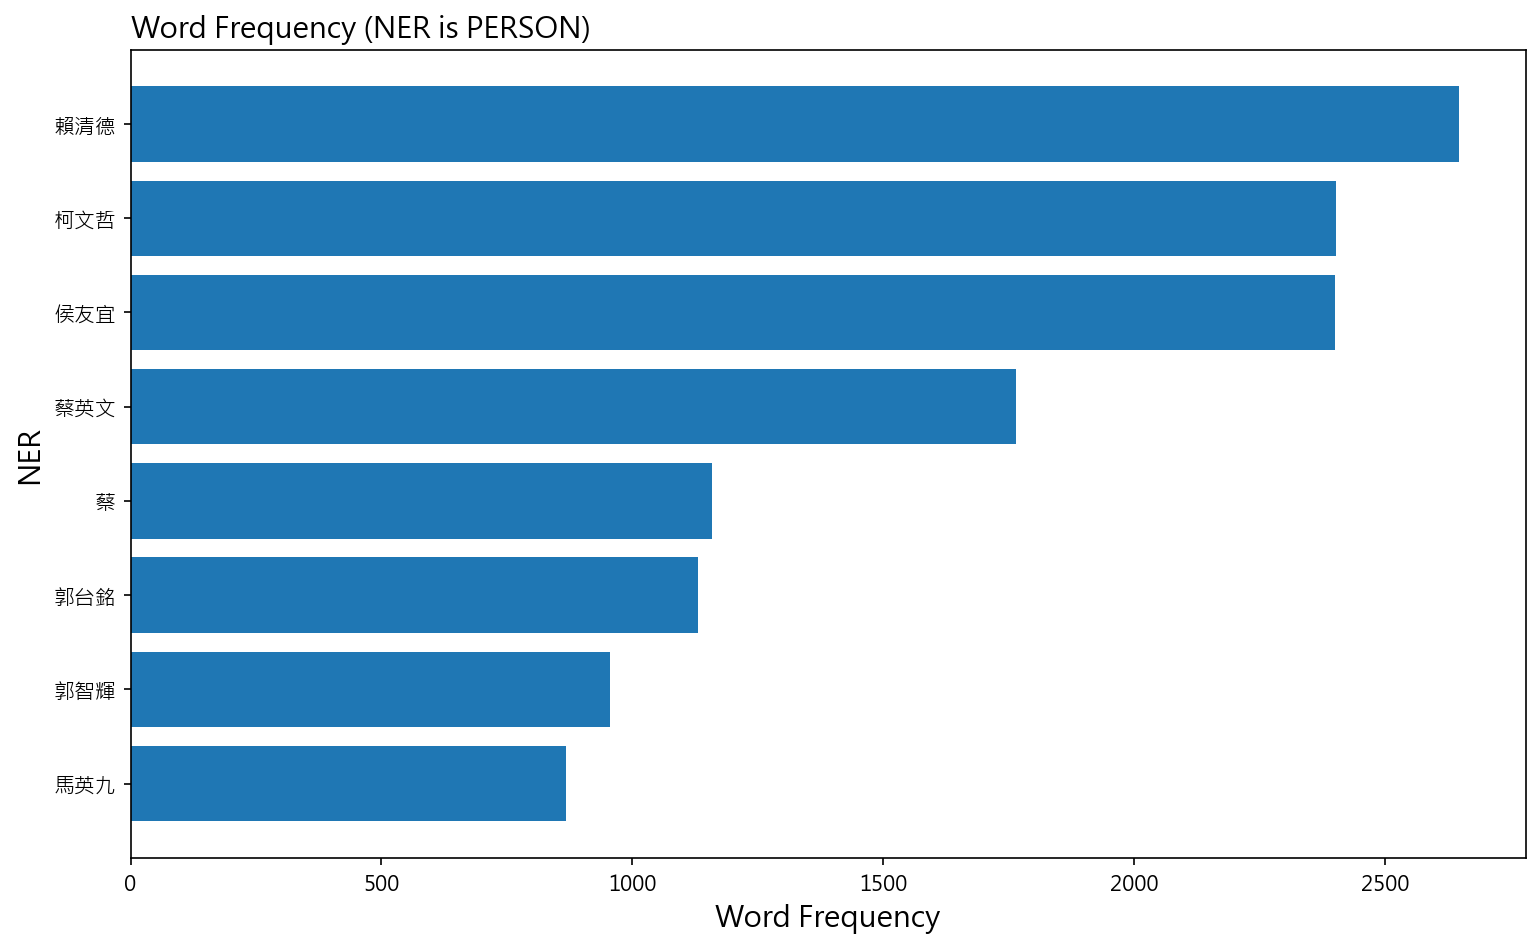

In [415]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

Text(0.5, 0, 'Word Frequency')

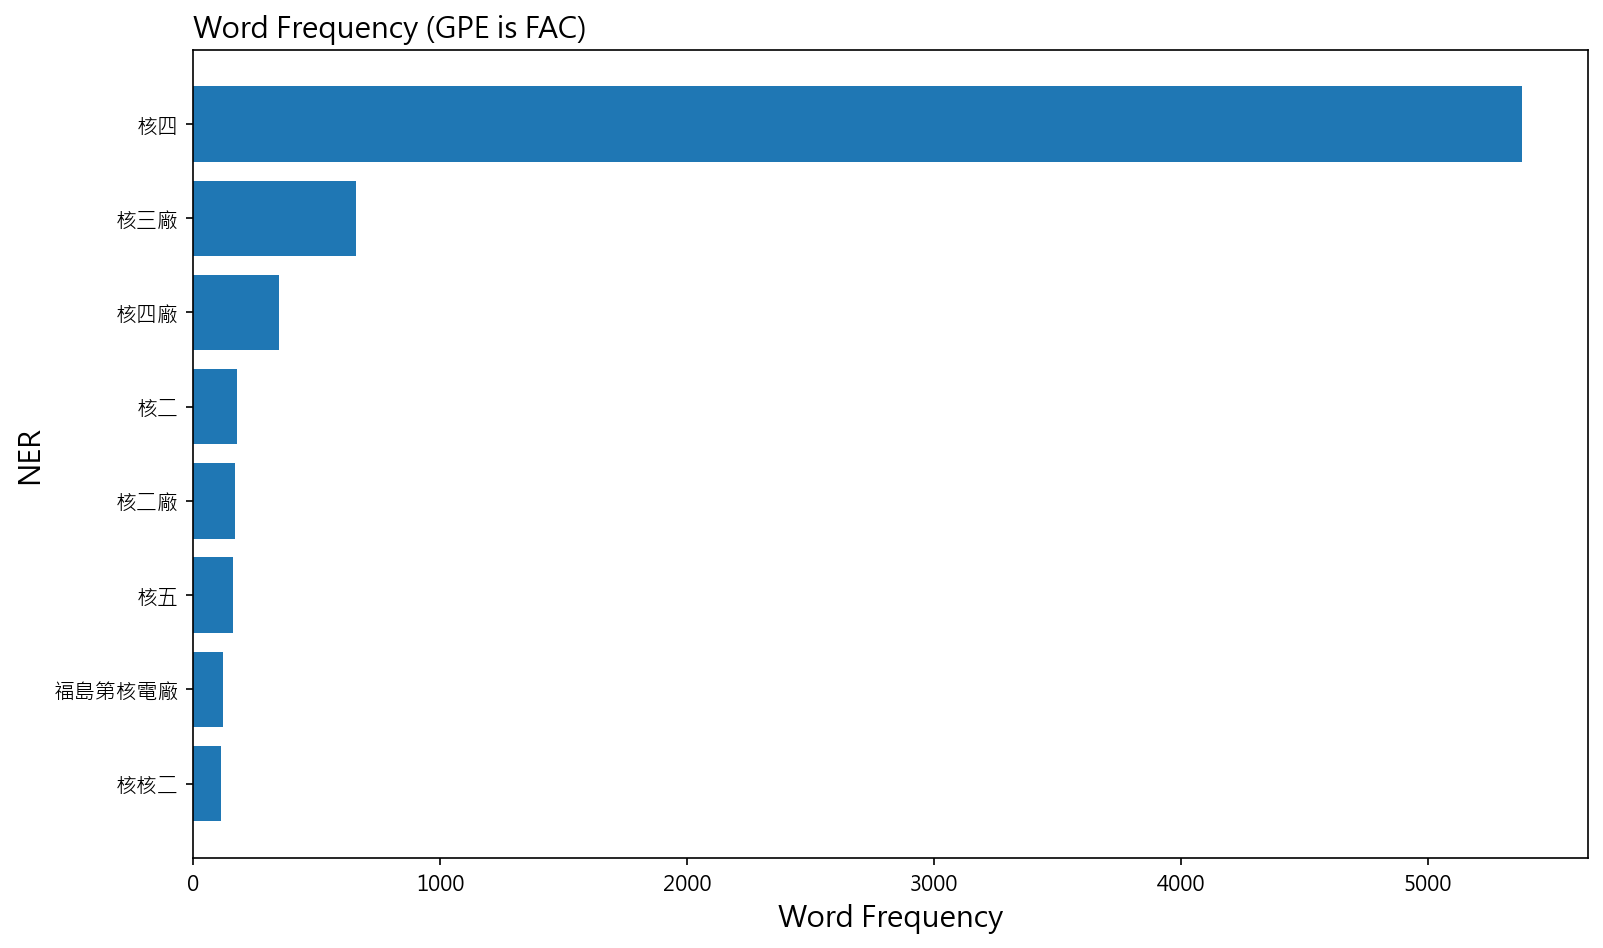

In [416]:
# 篩選ner為FAC的資料
l_noun = ["FAC"]
FAC = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = FAC.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (GPE is FAC)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

下面找出「核四」、「核四+賴清德」相關文章，與後續情緒分析一起做探索並對比

In [420]:
keyword_list = ['核四']
N4_selected = df[df['artContent'].fillna('').str.contains('|'.join(keyword_list), regex=True)]
print(f"{' '.join(keyword_list)}：{N4_selected.shape[0]}篇相關貼文")
N4_selected.head(3)

核四：2456篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
4,5,https://www.ptt.cc/bbs/HatePolitics/M.16231218...,Re:[新聞]5月底請辭陳培哲:最大困難就是來自蔡英文,2021-06-08,areses,HatePolitics,雖然我們一直說政治不能凌駕於科學，但那是正常情況下，政治本來就是一切社會關係的總\n和，也是...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""JamesSoong"",...",223.104.20.205,2021-06-09 01:53:43,ptt
7,8,https://www.ptt.cc/bbs/HatePolitics/M.16234727...,[討論]馬英九超級沒有擔當，退休還不放過台灣,2021-06-12,oftisa,HatePolitics,美豬美牛問題日本、韓國也有抗議\n韓國的抗議非常猛爆，日本只有黑道謝罪或是退幫才要切手指\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""goetze"", ""cm...",111.185.129.19,2021-06-13 02:05:13,ptt
11,12,https://www.ptt.cc/bbs/HatePolitics/M.16236568...,[新聞]CNN爆台山核電廠疑洩放射物質中方不斷,2021-06-14,meredith001,HatePolitics,1.新聞網址︰\nhttps://hk.appledaily.com/internation...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a0986188522""...",122.116.197.102,2021-06-15 01:38:19,ptt


In [422]:
keyword_list1 = ['核四', '賴清德']
mask = df['artContent'].fillna('').apply(lambda x: all(kw in x for kw in keyword_list1))
N4Lai_selected = df[mask]
print(f"{' '.join(keyword_list1)}：{N4Lai_selected.shape[0]}篇相關貼文")
N4Lai_selected.head(3)

核四 賴清德：215篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
22,23,https://www.ptt.cc/bbs/HatePolitics/M.16238316...,Re:[討論]柯文哲還有自信說我來指揮不會太差嗎？,2021-06-16,Sosonian,HatePolitics,這種廢文，隨便拿哪個政治人物來套都可以\n\n假設現在是馬英九還在當總統，蔡英文批核四政策，...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""nepenthes7"",...",114.198.166.7,2021-06-17 01:26:40,ptt
154,155,https://www.ptt.cc/bbs/HatePolitics/M.16356072...,[新聞]幕後》公投說明會桃園首發做球鄭文燦？,2021-10-30,zkow,HatePolitics,幕後》公投說明會桃園首發做球鄭文燦？民進黨順序安排嗅出2024端倪\n\n風傳媒 顏振凱\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""albert1229"",...",123.192.113.200,2021-10-31 00:44:12,ptt
162,163,https://www.ptt.cc/bbs/HatePolitics/M.16357386...,[新聞]賴清德：公投案牽涉台灣危機若過關將面,2021-11-01,nightwing,HatePolitics,1.新聞網址︰\nhttps://newtalk.tw/news/view/2021-11-...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a0986188522""...",106.1.248.69,2021-11-02 00:39:56,ptt


## 利用SnowNLP進行情緒分析

In [432]:
from snownlp import SnowNLP

sentence_table = pd.read_csv("sentence_table_Nu.csv") #匯資料
sentence_table1 = pd.read_csv("sentence_table_Nu.csv") 

sentiment_date = pd.merge(sentence_table,N4_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date1 = pd.merge(sentence_table,N4Lai_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()


def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date1['sentimentValue'] = sentiment_date1.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)

sentiment_date['sentimentValue'].describe()
sentiment_date1['sentimentValue'].describe()


count    2.373400e+04
mean     3.967722e-01
std      3.150285e-01
min      3.328879e-10
25%      1.186589e-01
50%      2.935473e-01
75%      6.417925e-01
max      9.999977e-01
Name: sentimentValue, dtype: float64

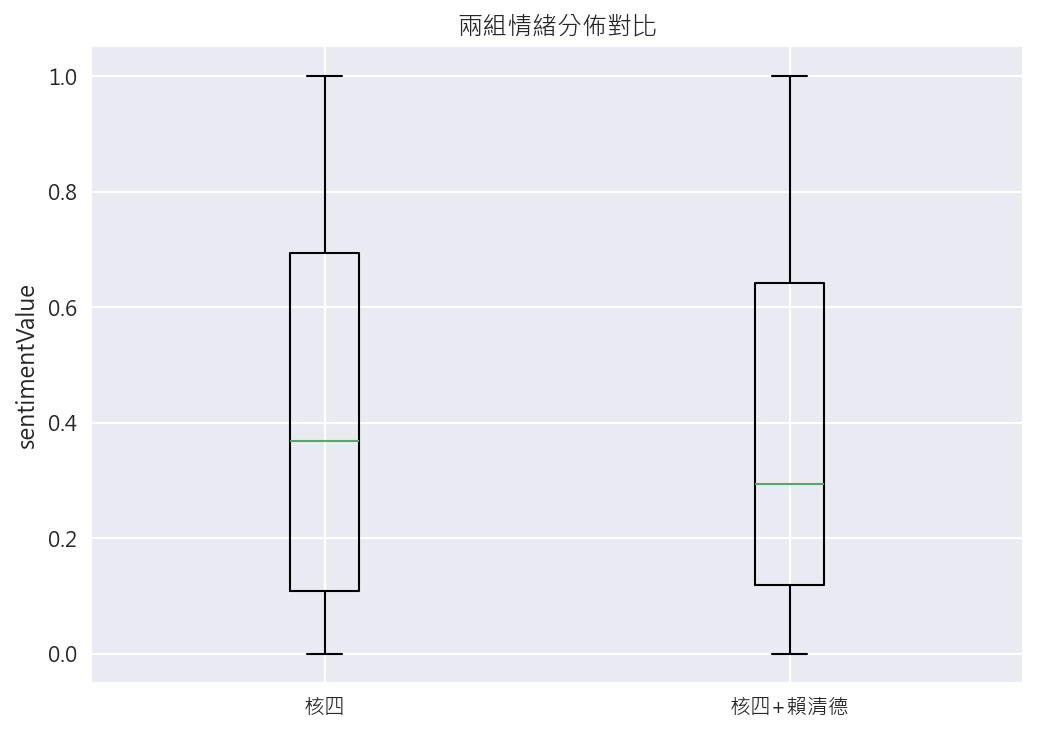

In [435]:
# 情緒分布的盒狀圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 使用微軟正黑體顯示中文
plt.rcParams['axes.unicode_minus'] = False

data_to_plot = [
    sentiment_date['sentimentValue'].dropna(),
    sentiment_date1['sentimentValue'].dropna()
]

plt.boxplot(data_to_plot, labels=['核四', '核四+賴清德'], showfliers=False)
plt.title('兩組情緒分佈對比')
plt.ylabel('sentimentValue')
plt.grid(True)
plt.show()

中位數差異：<br>
「核四」的情緒中位數略高（約 0.38）；<br>
「核四+賴清德」中位數略低（約 0.3 左右）。<br>

IQR（四分位距）差不多，但「核四+賴清德」有更多低情緒值，表示與政治人物連結後，情緒更極端、更分化。<br>

推論：<br>
將核電與政治人物（賴清德）連結後，討論情緒偏向更負面，代表核電議題一旦與選舉或政黨掛鉤，情緒分歧更劇烈。

In [446]:
sent_date = sentiment_date.copy()
sent_date1 = sentiment_date1.copy()

sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')
sent_date1['artDate'] =  pd.to_datetime(sentiment_date1['artDate']).dt.to_period('M')

sentiment_count  = (sent_date.groupby('artDate')['sentimentValue'].mean().reset_index().rename(columns={'sentimentValue':'sent_mean_A'}))
sentiment_count1 = (sent_date1.groupby('artDate')['sentimentValue'].mean().reset_index().rename(columns={'sentimentValue':'sent_mean_B'}))

sentiment_count['artDate_dt']  = sentiment_count['artDate'].dt.to_timestamp()
sentiment_count1['artDate_dt'] = sentiment_count1['artDate'].dt.to_timestamp()


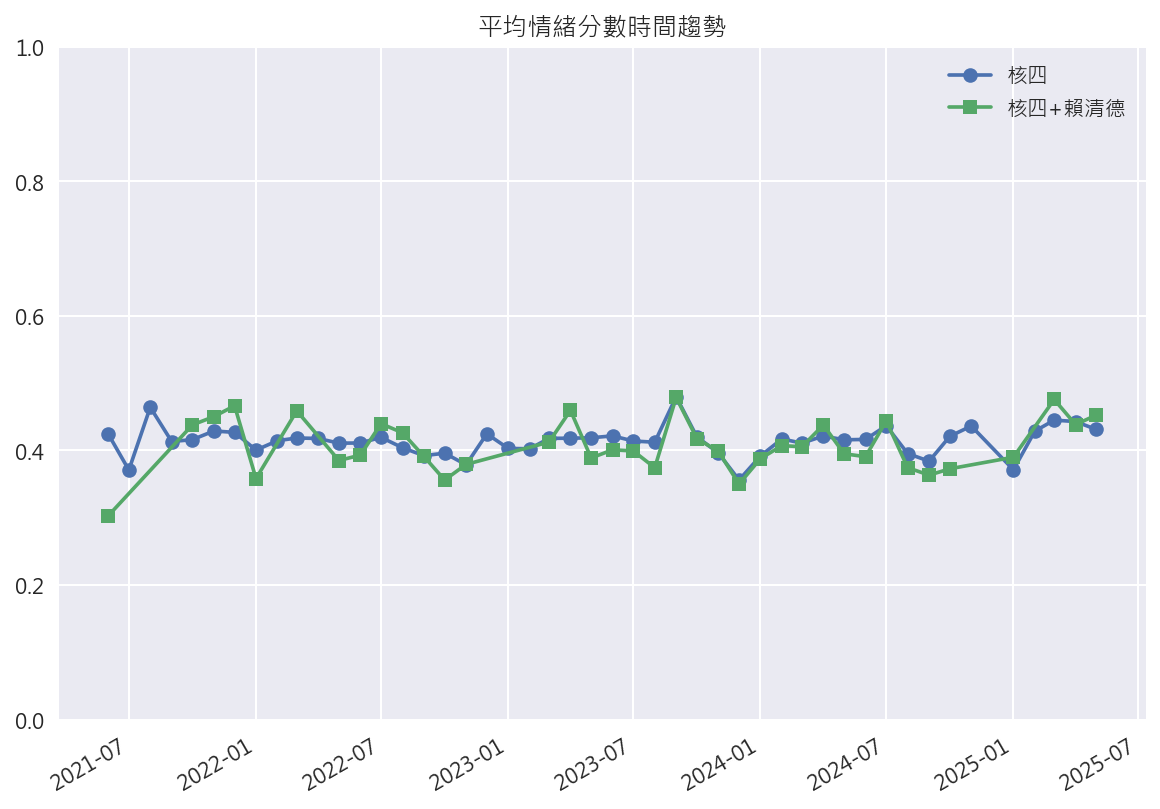

In [448]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sent_mean_A']
months1 = [period.to_timestamp() for period in sentiment_count1['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y1 = sentiment_count1['sent_mean_B']


plt.plot_date(months,  y,  fmt='-o', label='核四')
plt.plot_date(months1, y1, fmt='-s', label='核四+賴清德')

plt.title('平均情緒分數時間趨勢')
plt.legend()

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)
plt.show()




可以發現：<br>
在多數時期，「核四+賴清德」的平均情緒略低，特別在 2022 初、2023 初與 2025 初 的幾個點出現較明顯落差；<br>
2025 年中開始趨於一致且略為上升，可能與選後氛圍、政策定案等相關。<br>

補充推論：<br>
高峰時間一致但情緒高低有差：說明事件本身驅動討論，但人物連結放大了對立或偏見。

## 詞彙探索

In [449]:
filter_sentiment = sent_date[sent_date['artDate']=='2024-11']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.35]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
104859,3600,方圓十公里土地全部徵收,2024-11,ptt,0.289525
104862,3600,核廢料的問題,2024-11,ptt,0.209684
104863,3600,台灣很多無人島可以處理阿,2024-11,ptt,0.110700
104864,3600,基隆嶼,2024-11,ptt,0.104252
104866,3600,棉花嶼,2024-11,ptt,0.331020


In [450]:
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

,system_id,sentimentValue,word
0,3600,0.289525,核四
1,3600,0.289525,蓋
2,3600,0.289525,在
3,3600,0.289525,貢寮
4,3600,0.289525,那邊


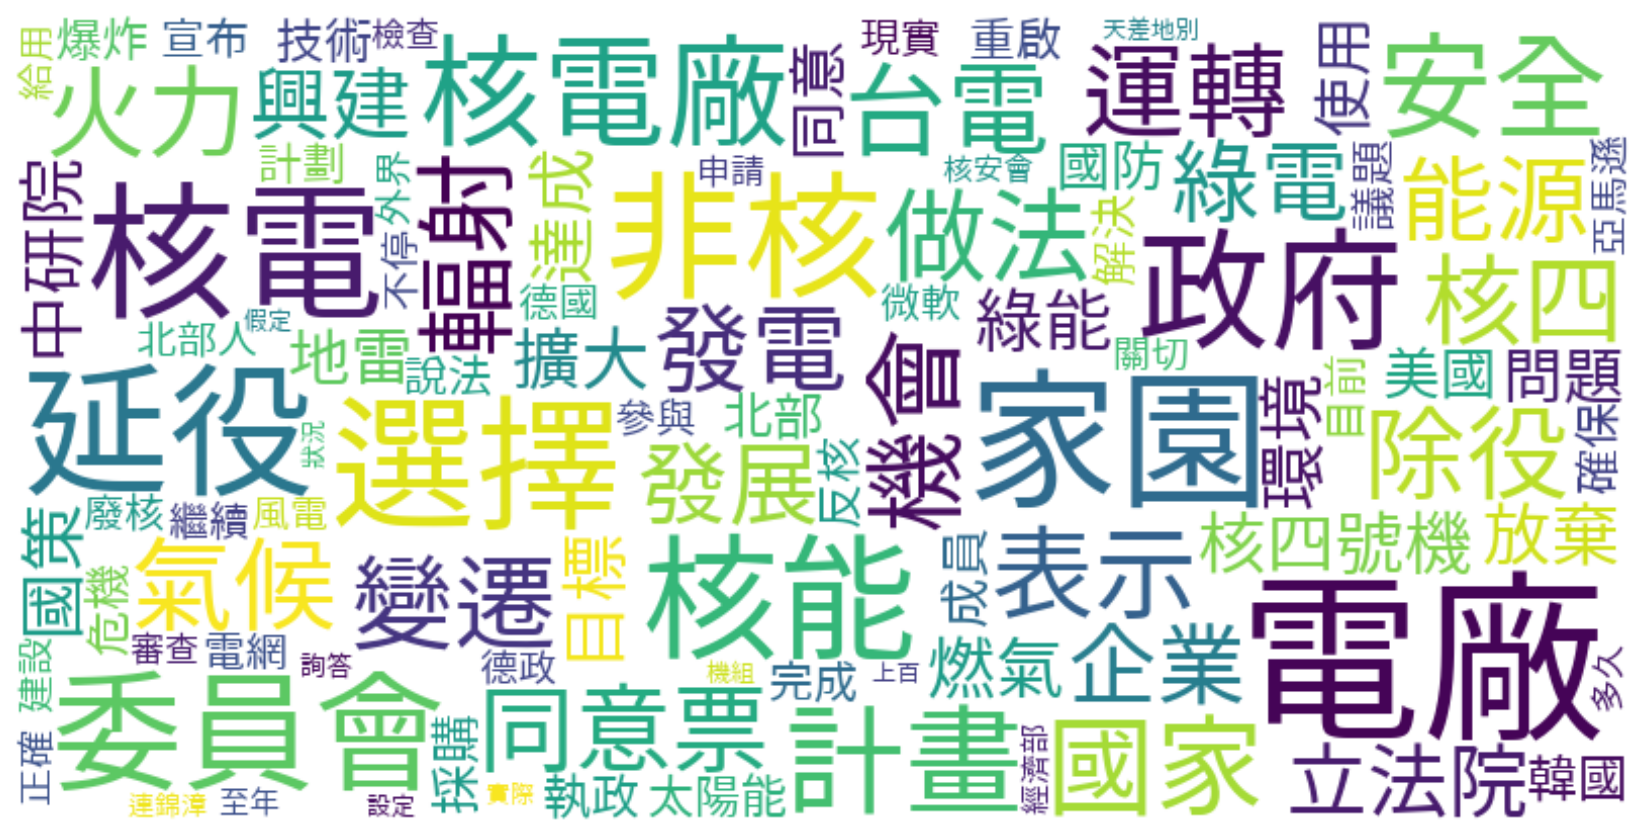

In [456]:
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]
# 自定停用字
with open('stopwords.txt') as f:
    stop_words = f.read().splitlines()

stop_words_pos = stop_words
stop_words_pos.extend(('我們','可以','現在','然後','請問','台灣','世界','之後','可能','甚至','今天','怎麼','需要','想要','院長','自己',
'已經','任何','時間','當然','跳出來','既然','如果','本來','不會','郭智','勢力','好像','叫做','看到','記者會','算出來','次長','上任','經濟部長','官員','常務',
'左右','反正','跑去'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

解讀：<br>
議題主軸從技術轉為政策與政治<br>
「核四+賴清德」相關討論中，政策語言出現率上升，例如「除役」「非核」「選擇」「委員會」，顯示焦點轉向決策正當性與政治立場。<br>

出現政黨語意與政績詞彙<br>
如「德政」「興建」「正確」「除役」「續建」等，可能帶有明顯的政治情緒傾向或肯定/否定立場。<br>

多重能源對比語境強烈<br>
「核電」與「綠電」「火力」同時被討論，顯示輿論不僅聚焦在核電本身，也在比較能源選擇背後的價值觀與政策路線。

# 主題模型

載入資料

In [ ]:
df = pd.read_csv("PTT_Nuclear.csv")
print(df.shape, df.columns)


(13622, 11) Index(['system_id', 'artUrl', 'artTitle', 'artDate', 'artPoster',
       'artCatagory', 'artContent', 'artComment', 'e_ip', 'insertedDate',
       'dataSource'],
      dtype='object')


依「提到次數」自動標註政黨

In [482]:
party_kw = {
    "國民黨":  r"國民黨|KMT|藍營|朱立倫|馬英九|侯友宜",
    "民進黨":  r"民進黨|DPP|綠營|蔡英文|賴清德|蘇貞昌",
    "民眾黨":  r"民眾黨|TPP|白營|柯文哲|柯主席|黃國昌",
}
def tag_party_by_count(row):
    text = f"{row.artTitle} {row.artContent}"
    counts = {p: len(re.findall(pattern, text, flags=re.I))
              for p, pattern in party_kw.items()}
    # 取最高值
    best_party, best_cnt = max(counts.items(), key=lambda x: x[1])
    # 若完全沒出現 → 其他
    return best_party if best_cnt > 0 else "其他"

df_nuke["party"] = df_nuke.apply(tag_party_by_count, axis=1)
print(df_nuke["party"].value_counts())

party
民進黨    2492
國民黨    1653
民眾黨     586
Name: count, dtype: int64


載入停用詞 & 斷詞

In [500]:
import re, jieba, string

with open("stopwords.txt", encoding="utf-8") as f:
    STOPWORDS = {w.strip() for w in f if w.strip()}

extra_stop = """
國民黨 民進黨 民眾黨 藍綠 藍白
柯文哲 賴清德 侯友宜 朱立倫 蔡英文 黃國昌 蘇貞昌 郭台銘 吳欣盈 賴品妤
台灣 中國 美國 大陸 俄羅斯 烏克蘭 兩岸 日本
國家 新聞 媒體 記者 公司 
直接 根本 這種 知道 賴皮 阿北 
""".split()
STOPWORDS.update(extra_stop)

#斷詞函式
def clean_cut(text: str):
    text = re.sub(r"http\S+|www\S+", "", text)      # 去網址
    text = re.sub(r"[0-9A-Za-z]+", "", text)        # 去英數
    tokens = [
        t for t in jieba.lcut(text)
        if (
            t.strip()                          # 去空字串
            and len(t) > 1                     # 只留兩字以上
            and t not in STOPWORDS
            and t not in string.punctuation
        )
    ]
    return tokens
    
df_nuke["artContent"] = df_nuke["artContent"].fillna("")

#新增 tokens 欄
df_nuke["tokens"] = df_nuke["artContent"].apply(clean_cut)

以三個政黨來訓練 LDA

In [501]:
NUM_TOPICS   = 4     # 3,5,7
RANDOM_STATE = 2025

lda_dict, lda_corpus, lda_model = {}, {}, {}

for p, sub in df_nuke.groupby("party"):
    tokenized = sub["tokens"].tolist()
    dictionary = Dictionary(tokenized)
    corpus     = [dictionary.doc2bow(t) for t in tokenized]
    lda        = LdaModel(
        corpus=corpus, id2word=dictionary,
        num_topics=NUM_TOPICS, random_state=RANDOM_STATE,
        chunksize=200, passes=10
    )
    lda_dict[p], lda_corpus[p], lda_model[p] = dictionary, corpus, lda
    
    print(f"\n=== {p} ===")
    for i, topic in lda.show_topics(num_words=10, formatted=False):
        words = " ".join(w for w, _ in topic)
        print(f"Topic {i}: {words}")



=== 國民黨 ===
Topic 0: 安全 國防 國安 經濟 重要 關係 中共 預算 中華民國 需要
Topic 1: 核四 廢料 核電 核電廠 重啟 公投 新北 處理 核能 反對
Topic 2: 台電 能源 核電 電價 延役 核能 政策 發電 成本 安全
Topic 3: 公投 立委 罷免 民主 完整 民眾 員工 今天 法案 廢死

=== 民眾黨 ===
Topic 0: 立委 核電 公投 民眾 完整 缺電 重啟 停電 廢料 核電廠
Topic 1: 核電 核四 公投 反核 台電 延役 支持 核三 能源 綠電
Topic 2: 能源 核電 核能 再生 發展 完整 政策 台電 綠電 民眾
Topic 3: 軍隊 飛彈 俄軍 地區 攻擊 進行 軍事 繼續 無人機 消息

=== 民進黨 ===
Topic 0: 公投 支持 核電 民主 核四 反核 執政 反對 看到 中共
Topic 1: 台電 核電 核能 能源 綠電 發電 電價 電力 核電廠 綠能
Topic 2: 能源 完整 核能 政策 非核 立委 社會 家園 發展 未來
Topic 3: 台南 雲豹 預算 綠能 綠電 疫苗 光電 掏空 勞工 跳票


🔵 國民黨：<br>
Topic 0（政治與戰略安全關聯）<br>
關鍵詞：安全、國防、國安、經濟、關係、中共、預算<br>
解讀：偏向戰略、國家安全與經濟政策論述，主打「大局穩定」與「國家利益」<br>
風格：強調外部威脅與內部治理結構、連結兩岸／國防意識形態<br>

Topic 1（核電正當性與民意對抗）<br>
關鍵詞：核四、廢料、處理、貢獻、公投、新北、能源、反對<br>
解讀：呈現核電相關爭議與地方 vs 中央、支持 vs 反對的分歧討論<br>
風格：核電是主軸，伴隨處理難題與政策拉扯（特別是地區民意與法規面）<br>

Topic 2（核能經濟與政策延役）<br>
關鍵詞：能源、電價、延役、政策、成本、安全<br>
解讀：聚焦在核能與能源政策的成本效益與延役管理<br>
風格：討論經濟實質與能源選擇，偏技術性與實務導向<br>


⚪ 民眾黨：主題分析<br>
Topic 0（公投與民眾基層反應）<br>
關鍵詞：立委、核電、公投、民眾、缺電、停電、廢料<br>
解讀：以「民眾視角」為出發點，關注基層能源問題與制度透明性<br>
風格：民意為導向，強調電力問題與民生困境的回應<br>

Topic 1（政策衝突與政黨立場交鋒）<br>
關鍵詞：反核、延役、支持、綠電、綠營、民眾<br>
解讀：描繪政治立場的碰撞，例如反核與支持核並存，以及對綠能的質疑<br>
風格：較具對抗性，呈現出能源議題被政治化的語境<br>

Topic 2（地緣衝突與軍事）<br>
關鍵詞：飛彈、俄軍、地區、進行、機器、消息<br>
解讀：納入國際議題（如烏俄戰爭）與國防相關語彙<br>
風格：較意外的一群，為特定時間段受烏俄戰爭影響造成的主題漂移<br>

🟢 民進黨：主題分析<br>
Topic 0（政策說明與治理論述）<br>
關鍵詞：支持、民主、核電、反核、執政、預算、中共<br>
解讀：將核電置於民主、執政與國家治理的脈絡中<br>
風格：理性論述風格，常見於政府或執政團隊的政策表述語料<br>

Topic 1（能源結構與社會議題）<br>
關鍵詞：能源、核能、政策、社會、氣候、未來<br>
解讀：談論核能在整體能源布局中的角色與與社會正義、環境議題交織<br>
風格：強調願景導向與氣候責任（如能源轉型）<br>

Topic 2（綠能與區域治理）<br>
關鍵詞：預算、綠能、疫苗、光電、綠能、台南<br>
解讀：出現與地方治理（如預算、疫苗施打）和綠能部署結合的情況<br>
風格：政策執行層面的用語，偏行政面而非論戰<br>

In [504]:
pyLDAvis.enable_notebook() 

for p in lda_model:
    vis = pyLDAvis.gensim_models.prepare(
        lda_model[p], lda_corpus[p], lda_dict[p], sort_topics=False
    )

    print(f"{p} 主題互動圖")  
    display(vis)   
    pyLDAvis.save_html(vis, f"lda_vis_{p}.html")   


國民黨 主題互動圖


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.234904 -0.065966       1        1  14.213506
1      0.050705 -0.056053       2        1  29.818374
2      0.168290 -0.095779       3        1  39.902690
3      0.015909  0.217799       4        1  16.065429, topic_info=     Term         Freq        Total Category  logprob  loglift
38     核四  1453.000000  1453.000000  Default  30.0000  30.0000
800    台電  2516.000000  2516.000000  Default  29.0000  29.0000
437    廢料  1357.000000  1357.000000  Default  28.0000  28.0000
691    能源  2241.000000  2241.000000  Default  27.0000  27.0000
1307   電價  1160.000000  1160.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
920    市長   129.642608   527.256969   Topic4  -5.8788   0.4256
338    議題   129.793585   602.163249   Topic4  -5.8777   0.2939
249    報導   121.318102   438.150003   Topic4  -5.9452   0.5444
40     核電   145.051714  2538.528198   Topic4  -5.7665  -1.0337
143    政策   126.660284  1308.767371   Topic4  -5.9021  -0.5068

[298 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2218      3  0.998208   .%
0         1  0.126620   一直
0         2  0.663089   一直
0         3  0.169937   一直
0         4  0.039985   一直
...     ...       ...  ...
1514      3  0.440664   黨團
1514      4  0.559052   黨團
3558      2  0.055053   黨部
3558      3  0.018351   黨部
3558      4  0.917551   黨部

[489 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

民眾黨 主題互動圖


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.054834  0.141502       1        1  15.971592
1      0.095650 -0.017905       2        1  28.859518
2      0.066672 -0.115868       3        1  34.778769
3     -0.217156 -0.007730       4        1  20.390121, topic_info=     Term        Freq       Total Category  logprob  loglift
84     能源  851.000000  851.000000  Default  30.0000  30.0000
484    核四  378.000000  378.000000  Default  29.0000  29.0000
4200   軍隊  160.000000  160.000000  Default  28.0000  28.0000
371    公投  422.000000  422.000000  Default  27.0000  27.0000
302    立委  265.000000  265.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
28     報告   40.319333   87.697174   Topic4  -6.2465   0.8131
4823   戰爭   39.563163   85.477202   Topic4  -6.2655   0.8198
711    使用   42.184867  155.963970   Topic4  -6.2013   0.2826
35     安全   42.991112  250.388790   Topic4  -6.1824  -0.1719
471    支持   42.946640  280.195384   Topic4  -6.1834  -0.2854

[311 rows x 6 columns], token_table=      Topic      Freq Term
term                      
330       1  0.015012   .%
330       2  0.120100   .%
330       3  0.855710   .%
0         1  0.077972   一下
0         2  0.888877   一下
...     ...       ...  ...
9261      4  0.959360   黨國
603       1  0.140970   黨團
603       2  0.135096   黨團
603       3  0.634365   黨團
603       4  0.093980   黨團

[547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

民進黨 主題互動圖


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.041239 -0.228919       1        1  21.042830
1      0.120152  0.021191       2        1  40.770858
2      0.157058  0.094221       3        1  27.481326
3     -0.235972  0.113508       4        1  10.704986, topic_info=     Term         Freq        Total Category  logprob  loglift
496    台電  3316.000000  3316.000000  Default  30.0000  30.0000
1540   完整  1056.000000  1056.000000  Default  29.0000  29.0000
1502   核能  3264.000000  3264.000000  Default  28.0000  28.0000
1421   綠電  2109.000000  2109.000000  Default  27.0000  27.0000
373    能源  4188.000000  4188.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
373    能源   113.780254  4188.744894   Topic4  -5.9992  -1.3714
108    立委    85.836857   816.359555   Topic4  -6.2810  -0.0179
5473   補助    70.191511   215.708567   Topic4  -6.4822   1.1118
74     政策    82.412399  2000.849578   Topic4  -6.3217  -0.9551
3540   億元    71.544500   398.686114   Topic4  -6.4631   0.5166

[312 rows x 6 columns], token_table=       Topic      Freq Term
term                       
926        1  0.348838   一直
926        2  0.607916   一直
926        3  0.014280   一直
926        4  0.028560   一直
17396      4  0.967678   不法
...      ...       ...  ...
2894       2  0.035266  黃士修
10069      2  0.077760   黑道
10069      4  0.913678   黑道
13119      4  0.989686   黑金
125        3  0.996300   黨團

[525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

1.情緒脈動：從「恐懼-憤怒」到「理性-經濟」
首輪 CKIP 情緒分類顯示，2018 以前討論核能多以「恐懼、憤怒」為主，聚焦於核災陰影與廢料疑慮；2021 公投前夕負向情緒達高峰，呈現「核四若重啟是否危及安全」的集體焦慮。第二輪，改用自訂詞庫＋機率分數的細粒度情緒模型後，負向詞頻雖仍占主流，但「理性-經濟」類（關切電價、能源缺口、產業前景）的中性／正向權重明顯上升，顯示隨缺電與能源轉型議題升溫，輿論開始用成本-效益框架重新審視核能，而非僅停留在災害想像。

2.政黨敘事：三條路徑的「核電框架競逐」
將貼文依政黨關鍵詞分流並建構四主題 LDA 後，可清楚看出：

國民黨以「國安＋經濟」雙軸敘事：致力將核電包裝為延役合法、降低電價、強化國安的解方，並透過「公投」與「重啟核四」爭取議題主導權。

民進黨聚焦「非核家園＋綠能投資」：強調安全、廢料與國際趨勢，輔以補貼電價與地方光電建設，試圖以轉型成就稀釋缺電質疑。

民眾黨則扮演「安全仲裁者」，一方面主張核電延役可緩解缺電，另一方面連結俄烏戰爭、飛彈威脅等國際安全因素，強化「能源安全」的第三種論述。

三黨雖同樣觸及電價與台電財務，但各自賦予截然不同的價值優先序——國民黨重「成本」、民進黨重「安全轉型」、民眾黨重「安全韌性」。

3.方法貢獻與侷限
透過動態擴充停用詞、單字過濾與片語訓練，最終 LDA 主題的語意一致度（c_v）落在 0.42 以上，已具可讀性；情緒模型則展現了時間序列下的敘事轉向。惟本研究仍受 PTT 族群偏好、匿名貼文文本長度不一及斷詞新詞召回率等限制，導致「人名／地名」殘留與局部雜訊；後續若能併入 Facebook、新聞稿與官方文件並以 Guided-LDA 微調子議題，可進一步驗證政黨框架在跨媒體間的一致性。

總結
整體而言，情緒分析揭示了大眾對核能的「情感遞變曲線」、主題模型刻劃了政黨在核電政策上的「框架競逐」。兩者相互印證：當輿論情緒從單純的恐懼、反對轉向經濟與安全計算時，政黨也同步調整敘事，從傳統「安全 vs. 反核」二分法，進化為「安全-經濟-轉型」三角賽局。未來若要形成社會共識，需在此三角中找到兼顧成本、風險與減碳目標的折衷方案，而非僅以單一價值主導公共論述。